In [1]:
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation, SimultaneousActivation, BaseScheduler
from mesa.datacollection import DataCollector
from mesa.visualization.modules import ChartModule
import numpy as np
import matplotlib.pyplot as plt
import random as rm

from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from termcolor import colored

In [25]:
class KeynesAgent(Agent):
    """
         Create a new PostKeynesian agent.
         Args:
            model: class model in wich the agent lives
            pos: Posicion of the agent (tuple or list?)
            v_c: Consume vector: informacion about the consuming behavior of the agent
                    (tuple, list, or numpy vector??)
        """
    D=dict(B=np.array([1,0,0]), M=np.array([0,1,0]), A=np.array([0,0,1]),
           MB=np.array([1,1,0]), AB=np.array([1,0,1]), AM=np.array([0,1,1]),
           AMB=np.array([1,1,1]))
    
    
    
#     # Clases sociales 
    
    D_med=[D['M'], D['MB'], D['AM']] # media: reglas 2,3,4,5
    D_alt=[D['A'], D['AB'], D['AMB']] # alta: reglas 2,3,4,5

#----------------------init method-------------------------------------------
    
    def __init__(self, model, pos, v_c, wealth):
        #self.model=model
        super().__init__(pos, model)
        self.pos = pos
        self.v_c = v_c
        self.clase = None # será = -1 si el agente es pobre, 0 si medio, 1 si es alta
        self.wealth = wealth
        
        self.coin = None
        self.vecindad = None
        self.suma_vecinos = None
        
        self.contador = 0
        
        


#------------------------------CONSUMO POR MODA--------------------------------------- 

    #reglas de actualización para clase baja
    def med_rules(self):

        s = self.suma_vecinos
        
        if s[1] > s[0] and s[1] > s[2]: #1 medio 
            self.v_c = self.D['M']
            self.clase = 0

        elif s[0] < s[2] and s[1] < s[2]: #2 medio
            self.v_c = self.D['AM']
            self.clase = 0
            
        elif s[2] < s[0] and s[1] < s[0]: #3 medio
            self.v_c = self.D['MB']
            self.clase =0

        elif s[0] == s[1]:
            self.v_c = self.D['MB']
            self.clase = 0
        
        elif s[1] == s[2]:
            self.v_c = self.D['AM']
            self.clase = 0
            
        elif s[0] == s[2]: #4 medio 
            self.v_c = self.D['AMB']
            self.clase = 1

    #reglas de actualización para clase alta
    def alt_rules(self):

        s= self.suma_vecinos

        if s[2] > s[0] and s[2] > s[1]: #5 alto
            self.v_c = self.D['A']
            self.clase = 1

        elif s[1] > s[0] and s[1] > s[2]: #6 alto
            self.v_c = self.D['AM']
            self.clase = 0

        elif s[1] < s[0] and s[2] < s[0]: #7 alto
            self.v_c = self.D['AB']
            self.clase = 1

        elif s[0] == s[1]: #8 alto
            self.v_c = self.D['AMB']
            self.clase = 1
        
        elif s[1] == s[2]:
            self.v_c = self.D['AM']
            self.clase = 0
        
        elif s[0] == s[2]:
            self.v_c =self.D['AB']
            self.clase = 1

    def vc_update(self):
        
        if self.clase == -1:
            
            self.vecindad = np.array([neig.v_c for neig in model.grid.get_neighbors(self.pos,moore=True)])
            self.suma_vecinos = self.vecindad.sum(0)
            #print(self.suma_vecinos)
            self.v_c = self.v_c
            self.clase = -1
            
        
        elif self.clase == 0:

            self.vecindad = np.array([neig.v_c for neig in model.grid.get_neighbors(self.pos,moore=True)])
            self.suma_vecinos = self.vecindad.sum(0)
            #print(self.suma_vecinos)
            self.med_rules()
           
        elif self.clase == 1:
            
            self.vecindad = np.array([neig.v_c for neig in model.grid.get_neighbors(self.pos,moore=True)])
            self.suma_vecinos = self.vecindad.sum(0)
            #print(self.suma_vecinos)
            self.alt_rules()
            

            
#----------------------------------------------------------------------------------
            
#----------------------------CONSUMO POR IMITACION---------------------------------
#modelo probabilistico de transito entre clases
                  
    def proba(self):

        D=dict(B=np.array([1,0,0]), M=np.array([0,1,0]), A=np.array([0,0,1]),
           MB=np.array([1,1,0]), AB=np.array([1,0,1]), AM=np.array([0,1,1]),
           AMB=np.array([1,1,1]))
        
        D_med=[D['M'], D['MB'], D['AM']] # media: reglas 2,3,4,5
        D_alt=[D['A'], D['AB'], D['AMB']] # alta: reglas 2,3,4,5
                  
        if self.clase == -1:

            coin = rm.choices([0,1], weights=[0.9,0.1] )[0]
            self.coin=coin
            if coin == 1:
                self.v_c = rm.choice(D_med)
                self.clase = 0
                

        elif self.clase == 0:

            coin3 = rm.choices([-1,0,1], weights=[0.1,0.8,0.1] )[0]
            self.coin=coin3
            #print(coin3)
            if coin3 == -1:
                self.v_c = D['B']
                self.clase = -1
            elif coin3 == 1:
                self.v_c = rm.choice(D_alt)
                self.clase = 1
                           
                
        elif self.clase == 1:
            coin = rm.choices([0,1], weights=[0.9,0.1] )[0]
            self.coin=coin
            if coin == 1:
                self.v_c = rm.choice(D_med)
                self.clase = 0
       
      
        #print(self.clase)
    
#---------------------------CONSUMO POR IMITACION------------------------------------------
#no probabilistico

    def select_producer(self,index):
        
        vecindad = self.model.grid.get_neighbors(self.pos,moore=True)
        #print([j.clase for j in vecindad])
        producers = []
        
        for a in vecindad: #puedo hacer esto en un list comprhension con condicional
            if a.clase == (index-1):
                producers.append(a)
        if len(producers) > 0:
            #print(producers)        
            lucky_prod = rm.choice(producers)
            lucky_prod.wealth += (index+1)
            self.wealth -= (index+1)
        
        #perdonar deuda y actualizar clase social
        
#         if self.wealth < 0:
#             self.wealth = 0
#             self.clase = -1
            
    def agent_spend(self):
        
        if self.wealth >= 1 and self.v_c[0] == 1: 
            #print('voy a gastar como pobre')
            self.select_producer(0)
            
        
        if self.wealth >= 2 and self.v_c[1] == 1:
            #print('voy a gastar como medio')
            self.select_producer(1)
            
        
        if self.wealth >= 3 and self.v_c[2] == 1:
            #print('voy a gastar como rico')
            self.select_producer(2)
            
            
    
    def balance(self):
        
        if self.wealth < 0:
            self.wealth = 0
            self.clase = -1
        elif  self.model.umbral_M <self.wealth < self.model.umbral_A:
            self.clase = 0
        else:
            self.clase = 1
               
        
        
#---------------------- STEP METHOD ---------------------------------
    #contador=0
    def step(self):
    #ojo con el orden de activación
        #self.vc_update()
        self.agent_spend()
        self.balance()
        
        #print('End of step')
#         self.contador += 1 #el contador es para introducir los volados cada "j" iteraciones
#         if self.contador%1 == 0: 
#             self.proba()
        
        
    

In [26]:
def bajos(model):
    cont = 0
    for a in model.schedule.agents:
        if a.clase == -1:
            cont += 1
            #cont += a.wealth
    return cont

def medios(model):
    cont = 0
    for a in model.schedule.agents:
        if a.clase == 0:
            cont += 1
            #cont += a.wealth
    return cont

def altos(model):
    cont = 0
    for a in model.schedule.agents:
        if a.clase == 1:
            cont += 1
            #cont += a.wealth
    return cont

def riqueza(model):
    cont=0
    for a in model.schedule.agents:
        cont += a.wealth
    return cont

In [4]:
class KeynesModel(Model):
    
    """Model class for the Postkeynessian consumer model"""
    def __init__(self, N, m, n, n_b, n_m, n_a):
        """
        N = numero de agentes
        m x n = numero total de celdas del modelo
            m = numero de filas
            n = numero de columnas
        *args = lista/tupla (??) con entradas n_b , n_m , n_a, donde
            n_b = numero de agentes de clase baja
            n_m = numero de agentes de clase media
            n_a = numero de agentes de clase alta
        """
        args=(n_b,n_m,n_a)
        
        if np.array(args).sum() != N:
            print("Error, la suma de agentes de cada clase no es igual a N")
        else:
            
            self.num_agents = N
            
            #umbrales de riqueza (puedo pedir los parametros: modificar los argumentos del init)
            self.umbral_M = 7
            self.umbral_A = 33
            self.wealth_MAX = 36
            #
            self.grid = SingleGrid(m, n, torus=True)
            self.schedule = BaseScheduler(self) 
            self.running = True
#             self.count = 0
#             self.count_cord = []
        
            #CREATE AGENTS
            # matrix of all coordinates, ramdom choosing from this to set agent's position and 
            # then  must asign V_c from a list of numpy arrays
            # order: clase baja, clase media, clase alta
            
            M=[(i,j) for i in range(m) for j in range(n)] #matriz de posiciones
            n_b, n_m, n_a=args[0], args[1], args[2] #linea innsecesaria
            for j in range(3):
                v_c=[0,0,0]
                for i in range(args[j]):
                    v_c[j]=1
                    #x = self.random.randrange(m)
                    #y = self.random.randrange(n)
                    #pos=(x,y)
                    pos=M.pop(M.index(rm.choice(M)))
                    #print(pos)
                    v_c=np.array(v_c)
                    
                    # random wealth generator
                    #comenzamos asignando con distribuciones uniformes
                    if j == 0:
                        w = rm.choice(range(self.umbral_M))
                    elif j == 1:
                        w = rm.choice(range(self.umbral_M,self.umbral_A))
                    else:
                        w = rm.choice(range(self.umbral_A,self.wealth_MAX))
                    #
                    a=KeynesAgent(self, pos, v_c, w)
                    a.clase = j-1
                    self.schedule.add(a)
                    self.grid.position_agent(a,pos) 
                    
        self.datacollector = DataCollector(
                model_reporters={"BAJOS": bajos, "MEDIOS": medios, "ALTOS": altos,"w_total":riqueza})
            

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
        

In [5]:
N, m, n, nb, nm, na = 100,10,10,50,25,25

In [6]:
model = KeynesModel(N, m, n, nb, nm, na)

In [7]:
a = model.schedule.agents[99]
w_ant=a.wealth
print(f'vector de consumo: {a.v_c}')
print(f'clase: {a.clase} ')
print(f'wealth: {a.wealth}')
print(f'pocision: {a.pos}')
ls=model.grid.get_neighbors(a.pos, moore=True)
vecs_vecinos=np.array([j.v_c for j in ls])
print(f'vecindad: {vecs_vecinos}')
print(f'sumavecinos:{vecs_vecinos.sum(0)}')
max([a.wealth for a in model.grid.get_neighbors(a.pos, moore=True)])

vector de consumo: [0 0 1]
clase: 1 
wealth: 34
pocision: (4, 8)
vecindad: [[1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]]
sumavecinos:[6 1 1]


34

In [8]:
len([])

0

In [9]:
model.step()

In [10]:
a = model.schedule.agents[99]
print(w_ant)
print(f'vector de consumo: {a.v_c}')
print(f'clase: {a.clase} ')
print(f'wealth: {a.wealth}')
max([a.wealth for a in model.grid.get_neighbors(a.pos, moore=True)])
# print(f'vecindad: {a.vecindad}')
# print(f'suma vecinos:{a.suma_vecinos}')

34
vector de consumo: [1 0 1]
clase: 1 
wealth: 34


31

In [11]:
max([a.wealth for a in model.schedule.agents])

35

# Visualizacion

In [27]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    
    D=dict(B=np.array([1,0,0]), M=np.array([0,1,0]), A=np.array([0,0,1]),
       MB=np.array([1,1,0]), AB=np.array([1,0,1]), AM=np.array([0,1,1]),
       AMB=np.array([1,1,1]))
    
    if (agent.v_c == D['B']).all() :
        portrayal["Color"] = "red"
        
    elif (agent.v_c == D['M']).all():
        portrayal["Color"] = "green" 
#     else:
#         portrayal["Color"] = "blue"
    elif (agent.v_c == D['A']).all():
        portrayal["Color"] = "blue"
        
    elif (agent.v_c == D['MB']).all():
        portrayal["Color"] = "yellow"
        
    elif (agent.v_c == D['AB']).all():
        portrayal["Color"] = "#778899"#"#FF1493" #rosa mexicano
        
    elif (agent.v_c == D['AM']).all():
        portrayal["Color"] = "#48D1CC" #turquesa bonito
        
    elif (agent.v_c == D['AMB']).all():
        portrayal["Color"] = "#000000" #negro
    else :
        portrayal["Color"] = "#FFFFFF" #blanco
        
      
    return portrayal

In [28]:
def agent_portrayal2(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    
#     D=dict(B=np.array([1,0,0]), M=np.array([0,1,0]), A=np.array([0,0,1]),
#        MB=np.array([1,1,0]), AB=np.array([1,0,1]), AM=np.array([0,1,1]),
#        AMB=np.array([1,1,1]))
    
    if agent.clase == -1 :
        portrayal["Color"] = "red"
        
    elif agent.clase == 0:
        portrayal["Color"] = "green" 
#     else:
#         portrayal["Color"] = "blue"
    else:
        portrayal["Color"] = "blue"
        
#     elif (agent.v_c == D['MB']).all():
#         portrayal["Color"] = "yellow"
        
#     elif (agent.v_c == D['AB']).all():
#         portrayal["Color"] = "#778899"#"#FF1493" #rosa mexicano
        
#     elif (agent.v_c == D['AM']).all():
#         portrayal["Color"] = "#48D1CC" #turquesa bonito
        
#     elif (agent.v_c == D['AMB']).all():
#         portrayal["Color"] = "#000000" #negro
#     else :
#         portrayal["Color"] = "#FFFFFF" #blanco
        
      
    return portrayal

In [29]:
#parametros del modelo
N, m, n, nb, nm, na = 100,10,10,70,20,10

In [30]:
bj = {"Label": "BAJOS", "Color": "Red"}
md = {"Label": "MEDIOS", "Color": "Green"}
lt = {"Label": "ALTOS", "Color": "Blue"}
chart = ChartModule([bj, md, lt],
                    data_collector_name='datacollector')

In [31]:
w_t = {"Label": "w_total", "Color": "Black" }
chart2 = ChartModule([w_t],data_collector_name="datacollector")

In [33]:
grid = CanvasGrid(agent_portrayal, m, n, 500, 500)
grid_2 = CanvasGrid(agent_portrayal2, m, n, 500, 500)
server = ModularServer(KeynesModel,
                       [grid,grid_2,chart,chart2],
                       "Post-Keynesian Model",
                       {"N":N, "m":m, "n":n, "n_b":nb, "n_m":nm, "n_a":na})
server.port = 1123# The default
server.launch()

Interface starting at http://127.0.0.1:1123


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step":32}
{"type":"get_step

{"type":"get_step","step":268}
{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}


In [ ]:
dir(server
   )

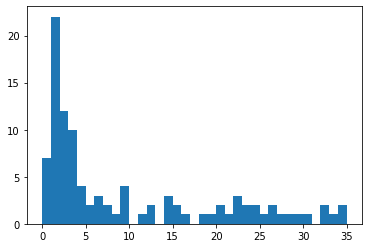

In [18]:
all_wealth=[]
for agent in server.model.schedule.agents:
    all_wealth.append(agent.wealth)
plt.hist(all_wealth, bins=range(max(all_wealth)+1))
plt.show()

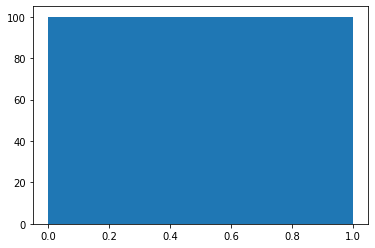

In [19]:
all_wealth=[]
for agent in server.model.schedule.agents:
    all_wealth.append(agent.clase)
plt.hist(all_wealth, bins=range(max(all_wealth)+1))
plt.show()

In [20]:
all_wealth

[1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


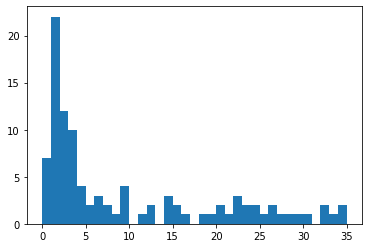

In [24]:
all_wealth=[]
for agent in server.model.schedule.agents:
    if agent.wealth <= 7:
        print(agent.clase)
    all_wealth.append(agent.wealth)
plt.hist(all_wealth, bins=range(max(all_wealth)+1))
plt.show()
